In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any


df = pd.read_csv('Kel 4 Data PPKS 1(2018).csv', delimiter=';')

# konversi "," ke "."
df = df.replace(',', '.', regex=True)

# konversi tipe data ke numerik
df = df.apply(pd.to_numeric)

X = df.drop(columns=['PPKS'], axis=1)
y = df['PPKS']

df.head()

,total_penduduk,umk,rata_ak,ipm_pr,pengeluaran_kapita,PPKS
0,1719504,1841209.0,3.71,64.61,10274,326422
1,1679124,1589000.0,3.70,66.75,11240,220085
2,925193,1655200.0,4.02,66.86,9786,133413
3,918219,1490000.0,3.83,64.98,9160,100609
4,1195092,1560000.0,3.73,67.48,8757,140104


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_penduduk      35 non-null     int64  
 1   umk                 35 non-null     float64
 2   rata_ak             35 non-null     float64
 3   ipm_pr              35 non-null     float64
 4   pengeluaran_kapita  35 non-null     int64  
 5   PPKS                35 non-null     int64  
dtypes: float64(3), int64(3)
memory usage: 1.8 KB


## Class untuk Regresi Linear Berganda

In [3]:
class MultipleLinearRegression:
    def __init__(self):
        self.coef_ = None # simpan [b1, b2, ..., bn]
        self.beta = None # simpan intercept (alpha)

    def fit(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        X_bias = np.column_stack((np.ones(X.shape[0]), X))
        self.beta = np.linalg.inv(X_bias.T @ X_bias) @ X_bias.T @ y

        print(f'-'*50)
        print('Intercept (a):', self.beta[0])
        print('Coefficients (b):', self.beta[1:])
        print(f'-'*50)

        # print the regression equation
        terms = [f"{self.beta[i+1]:.2f}X{i+1}" for i in range(X.shape[1])]
        print("Persamaan Regresi:")
        print(f"Y = {self.beta[0]:.2f} + " + " + ".join(terms))

        return self.beta
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        X_bias = np.column_stack((np.ones(X.shape[0]), X))
        y_pred = X_bias @ self.beta
        return y_pred
    
    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        '''
        Mengembalikan nilai R^2 score (0-1)
        '''
        y_pred = self.predict(X) # prediksi nilai y

        y_bar = np.mean(y) # rata-rata nilai aktual
        jkt = np.sum((y - y_bar) ** 2)
        jkr = np.sum((y_pred - y_bar) ** 2)
        r2 = (jkr / jkt)
        return r2

## Pearson Correlation Function

In [4]:
def pearson_correlation(x1:np.ndarray, x2:np.ndarray) -> float:
    x1_arr = np.array(x1, dtype=float)
    x2_arr = np.array(x2, dtype=float)
    
    n = x1_arr.size
    sum_x1 = np.sum(x1_arr)
    sum_x2 = np.sum(x2_arr)
    sum_x1x2 = np.sum(x1_arr * x2_arr)
    sum_x1_2 = np.sum(x1_arr ** 2)
    sum_x2_2 = np.sum(x2_arr ** 2)

    numerator = n * sum_x1x2 - sum_x1 * sum_x2
    denominator = np.sqrt((n * sum_x1_2 - sum_x1 ** 2) * (n * sum_x2_2 - sum_x2 ** 2))

    if denominator == 0:
        raise ValueError("Tidak bisa membagi dengan 0; tidak bisa menghitung korelasi")

    return numerator / denominator

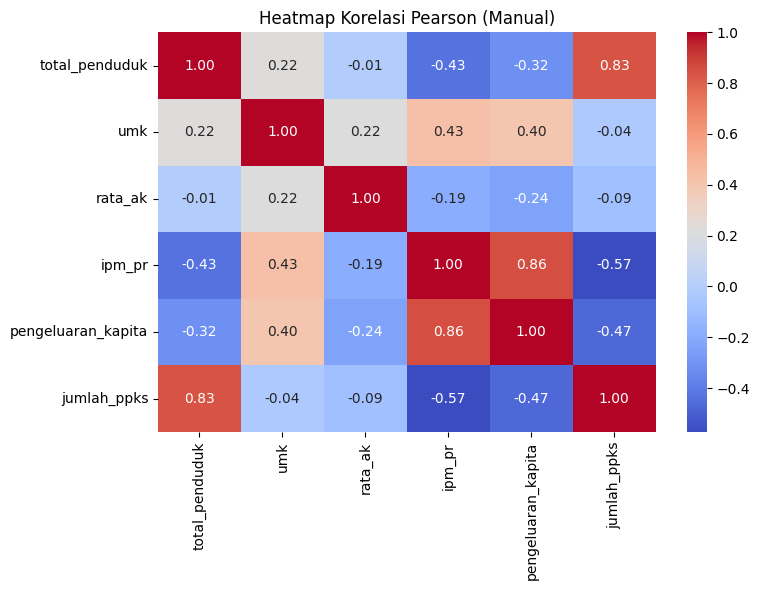

In [5]:
def compute_pearson_correlation_matrix(df ,corr_func: Any) -> pd.DataFrame:

    cols = df.columns
    n = len(cols)
    corr_matrix = np.zeros((n, n), dtype=float)
    for i, col1 in enumerate(cols):
        for j, col2 in enumerate(cols):
            if i <= j:
                corr = corr_func(df[col1].values, df[col2].values)
                corr_matrix[i, j] = corr
                corr_matrix[j, i] = corr  # symmetric
    return pd.DataFrame(corr_matrix, index=cols, columns=cols)

# gabungkan X dan y
df_corr = X.copy()
df_corr['jumlah_ppks'] = y

# hitung matriks korelasi pearson manual
corr_matrix = compute_pearson_correlation_matrix(df_corr, pearson_correlation)

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
)
plt.title("Heatmap Korelasi Pearson (Manual)")
plt.tight_layout()
plt.show()


In [6]:
correlations = {}
for column in X.columns:
    x = X[column].values
    correlations[column] = pearson_correlation(x, y)

# Menampilkan hasil korelasi
print("Matriks Korelasi Manual:")
for var, corr in correlations.items():
    print(f"Korelasi antara {var} dan jumlah_ppks: {corr:.4f}")

Matriks Korelasi Manual:
Korelasi antara total_penduduk dan jumlah_ppks: 0.8343
Korelasi antara umk dan jumlah_ppks: -0.0379
Korelasi antara rata_ak dan jumlah_ppks: -0.0890
Korelasi antara ipm_pr dan jumlah_ppks: -0.5731
Korelasi antara pengeluaran_kapita dan jumlah_ppks: -0.4698


In [7]:
model = MultipleLinearRegression()

model.fit(X, y)
y_pred = model.predict(X)

model.score(X, y)

--------------------------------------------------
Intercept (a): 379081.5872522922
Coefficients (b): [ 1.19034044e-01 -2.83383013e-02 -4.04938666e+04 -2.06763308e+03
 -3.40458320e+00]
--------------------------------------------------
Persamaan Regresi:
Y = 379081.59 + 0.12X1 + -0.03X2 + -40493.87X3 + -2067.63X4 + -3.40X5


0.7747795151253603